In [ ]:
import tqdm
import os
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from torch import nn, optim
from torch.optim import Adam
from torch.utils.data import Dataset
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from ipywidgets import interact
from rich.progress import Progress,TimeElapsedColumn,TimeRemainingColumn,BarColumn,TextColumn

In [ ]:
class SegVid(Dataset):
    def __init__(self,fpath,num):
        self.vid = []
        self.masks = []
        self.imgs = []
        dirs = sorted(os.listdir(fpath))
        dirs = [d for d in dirs if d[0]=='v']
        for path in tqdm.tqdm(dirs[:num]):
            if path[0]!='v':
                continue
            video = []
            for i in range(11):
                frame_path=os.path.join(fpath,path,'image_'+str(i)+'.png')
                frame = (transforms.ToTensor())(Image.open(frame_path).convert('RGB'))
                video.append(frame)
            video=torch.stack(video)
            self.vid.append(video)
            frame_path=os.path.join(fpath,path,'image_'+str(21)+'.png')
            frame = (transforms.ToTensor())(Image.open(frame_path).convert('RGB'))
            self.imgs.append(frame)
            mask_path = os.path.join(fpath,path,'mask.npy')
            mask = torch.Tensor(np.load(mask_path))
            self.masks.append(mask[21])

    def __len__(self):
        return len(self.vid)

    def __getitem__(self,idx):
        return self.vid[idx],self.masks[idx]

    def get_image(self,idx):
        return self.imgs[idx],self.masks[idx]

# Load from GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf __MACOSX

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/NYU_DL_task/train.zip > /dev/null
train_data_seg = SegVid('train',1000)
!rm -rf train

100%|██████████| 1000/1000 [00:23<00:00, 42.23it/s]


In [ ]:
!unzip /content/drive/MyDrive/NYU_DL_task/val.zip > /dev/null
!rm -rf val/video_01370
val_data_seg = SegVid('val',1000)
!rm -rf val

100%|██████████| 998/998 [00:21<00:00, 45.48it/s]


In [ ]:
######### SIMVP ########

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, transpose=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm=act_norm
        if not transpose:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=stride //2 )
        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, stride, transpose=False, act_norm=True):
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(C_in, C_out, kernel_size=3, stride=stride,
                                padding=1, transpose=transpose, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups, act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm = act_norm
        if in_channels % groups != 0:
            groups = 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class Inception(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker=[3,5,7,11], groups=8):
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)
        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker, stride=1, padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y

        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y

def stride_generator(N, reverse=False):
    strides = [1, 2]*10
    if reverse: return list(reversed(strides[:N]))
    else: return strides[:N]

class Encoder(nn.Module):
    def __init__(self,C_in, C_hid, N_S):
        super(Encoder,self).__init__()
        strides = stride_generator(N_S)
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, stride=strides[0]),
            *[ConvSC(C_hid, C_hid, stride=s) for s in strides[1:]]
        )

    def forward(self,x):# B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1,len(self.enc)):
            latent = self.enc[i](latent)
        return latent,enc1


class Decoder(nn.Module):
    def __init__(self,C_hid, C_out, N_S):
        super(Decoder,self).__init__()
        strides = stride_generator(N_S, reverse=True)
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, stride=s, transpose=True) for s in strides[:-1]],
            ConvSC(2*C_hid, C_hid, stride=strides[-1], transpose=True)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        for i in range(0,len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](torch.cat([hid, enc1], dim=1))
        Y = self.readout(Y)
        return Y

class Mid_Xnet(nn.Module):
    def __init__(self, channel_in, channel_hid, N_T, incep_ker = [3,5,7,11], groups=8):
        super(Mid_Xnet, self).__init__()

        self.N_T = N_T
        enc_layers = [Inception(channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))

        dec_layers = [Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_in, incep_ker= incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y


class SimVP(nn.Module):
    def __init__(self, shape_in, hid_S=16, hid_T=256, N_S=4, N_T=8, incep_ker=[3,5,7,11], groups=8):
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        self.enc = Encoder(C, hid_S, N_S)
        self.hid = Mid_Xnet(T*hid_S, hid_T, N_T, incep_ker, groups)
        self.dec = Decoder(hid_S, C, N_S)


    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.view(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
        return Y

########## UNET ############
class CONVB(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.pass1 = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(output_channels),
                                  nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(output_channels),
                                  nn.ReLU())
    def forward(self, inputs):
        return self.pass1(inputs)

class UP(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.pass1 = CONVB(input_channels, output_channels)
        self.pass2 = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.pass1(inputs)
        y = self.pass2(x)
        return (x,y)

class DOWN(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()

        self.pass1 = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2, padding=0)
        self.pass2 = CONVB(output_channels+output_channels, output_channels)


    def forward(self, inputs, aux):
        x = self.pass1(inputs)
        x = torch.cat([x, aux], axis=1)
        x = self.pass2(x)

        return x

class OUTC(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.pass1 = nn.Conv2d(input_channels, output_channels, kernel_size=1, padding=0)

    def forward(self, inputs):
        return self.pass1(inputs)

class UPSTREAM(nn.Module):
    def __init__(self, input_channels,mc1,mc2,mc3,con1,output_channels):
        super().__init__()

        self.pass1 = UP(input_channels,mc1)
        self.pass2 = UP(mc1,mc2)
        self.pass3 = UP(mc2,mc3)
        self.pass4 = UP(mc3,con1)
        self.pass5 = CONVB(con1,output_channels)

    def forward(self, inputs):
        x1,y1 = self.pass1(inputs)
        x2,y2 = self.pass2(y1)
        x3,y3 = self.pass3(y2)
        x4,y4 = self.pass4(y3)
        z = self.pass5(y4)
        return z,x1,x2,x3,x4

class DOWNSTREAM(nn.Module):
    def __init__(self, input_channels,mc1,mc2,mc3,output_channels):
        super().__init__()
        self.d1 = DOWN(input_channels, mc1)
        self.d2 = DOWN(mc1, mc2)
        self.d3 = DOWN(mc2, mc3)
        self.d4 = DOWN(mc3, output_channels)

    def forward(self,a,b,c,d,e):
        x1 = self.d1(a,e)
        x2 = self.d2(x1,d)
        x3 = self.d3(x2,c)
        x4 = self.d4(x3,b)
        return x4


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pass1 = UPSTREAM(3,64,128,256,512,1024)
        self.pass2 = DOWNSTREAM(1024,512,256,128,64)
        self.pass3 = OUTC(64,49)

    def forward(self, inputs):
        x,y1,y2,y3,y4 = self.pass1(inputs)
        x = self.pass2(x,y1,y2,y3,y4)
        x = self.pass3(x)
        return x

In [ ]:
class vdU_pred(nn.Module):
    def __init__(self):
        super(vdU_pred, self).__init__()
        self.vp = SimVP((11,3,160,240))
        self.un = UNet()

    def forward(self,x):
        pred_vid = self.vp(x)
        seg = self.un(pred_vid[:,10,:,:,:])
        return seg

    def fix_vp(self):
        for param in self.vp.parameters():
            param.requires_grad = False

    def fix_un(self):
        for param in self.un.parameters():
            param.requires_grad = False

    def unfix_vp(self):
        for param in self.vp.parameters():
            param.requires_grad = True

    def unfix_un(self):
        for param in self.un.parameters():
            param.requires_grad = True

    def load_weights(self,fpathv,fpathu,device):
        PATH = fpathv
        self.vp.load_state_dict(torch.load(PATH,map_location=device))
        PATH = fpathu
        self.un.load_state_dict(torch.load(PATH,map_location=device))

In [ ]:
batch_size=16
train_loader = DataLoader(train_data_seg, shuffle=True, batch_size=batch_size)

In [ ]:
batch_size=16
val_loader = DataLoader(val_data_seg, shuffle=True, batch_size=batch_size)

In [ ]:
def iou(pred, target, n_classes):
    # pred and target shapes are (batch_size, 1, H, W)
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(float(intersection) / union)


    ious = [x for x in ious if not np.isnan(x)]
    if len(ious) == 0:
        return float('nan')
    return np.mean(ious)

# UnFixed video predictor

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vdU_pred().to(device)

#first run
#model.load_weights('/content/drive/MyDrive/NYU_DL_task/weights/SimVP_w','/content/drive/MyDrive/NYU_DL_task/weights/UNet_w',device) #deprecated do not uncomment
#model.fix_vp() # do not comment

#optional later runs
model.load_state_dict(torch.load('/content/drive/MyDrive/NYU_DL_task/weights1/epoch300',map_location=device))

optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.CrossEntropyLoss()

<ipython-input-12-c5810cfb72ed>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/NYU_DL_task/weights1/epoch300',map_

# Model Training

In [ ]:
num_epochs = 100
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []
with Progress(TextColumn("{task.description}"),BarColumn(),TimeElapsedColumn(),TimeRemainingColumn()) as pb:
    t1 = pb.add_task('Training',total=len(train_loader))
    t2 = pb.add_task('Validation',total=len(val_loader))
    t3 = pb.add_task('Epoch',total=num_epochs)
    val_check=False

    for epoch in range(num_epochs):
        net_train_iou = 0
        tot_train_loss = 0
        inner_iter = 0
        model.train()
        for batch in train_loader:
            data,target = [x.to(device) for x in batch]
            pred = model(data)
            IOU = iou(torch.argmax(pred,dim=1), target,49)
            net_train_iou+=IOU
            loss = criterion(pred,target.long())
            loss.backward()
            optim.step()
            optim.zero_grad()
            cur_loss = loss.item()
            tot_train_loss += cur_loss
            pb.update(t1,completed=inner_iter+1,description=f'Training Batch: {(inner_iter+1)}/{len(train_loader)} Loss: {round(cur_loss,5)} IOU: {round(IOU,5)}')
            inner_iter += 1


        if (epoch+1)%10==0:  #validation every 10 epochs
            model.eval()
            inner_iter = 0
            val_check=True
            tot_val_loss = 0
            net_val_iou=0


            for batch in val_loader:
                data,target = [x.to(device) for x in batch]
                with torch.no_grad():
                    pred = model(data)
                    IOU = iou(torch.argmax(pred,dim=1), target,49)
                    net_val_iou+=IOU
                    loss = criterion(pred,target.long())
                cur_loss = loss.item()
                tot_val_loss += cur_loss
                pb.update(t2,completed=inner_iter+1,description=f'Validation Batch: {(inner_iter+1)}/{len(val_loader)} Loss: {round(cur_loss,5)} IOU: {round(IOU,5)}')
                inner_iter += 1
            val_loss_list.append(tot_val_loss/len(val_loader))
            val_iou_list.append(net_val_iou/len(val_loader))
        if val_check:
            pb.update(t3,completed=epoch+1,description=f'Epoch: {(epoch+1)} Loss: {round(tot_train_loss/len(train_loader),5)} IOU: {round((net_train_iou)/len(train_loader),5)} VLoss: {round(tot_val_loss/len(val_loader),5)} VIOU: {round((net_val_iou)/len(val_loader),5)}')
        else:
            pb.update(t3,completed=epoch+1,description=f'Epoch: {(epoch+1)} Loss: {round(tot_train_loss/len(train_loader),5)} IOU: {round((net_train_iou)/len(train_loader),5)} VLoss: -- VIOU: --')
        train_loss_list.append(tot_train_loss/len(train_loader))
        train_iou_list.append(net_train_iou/len(train_loader))

    pb.refresh()

Output()

In [ ]:
model_save_name = 'epoch'+str(500)
#if 'weights' not in os.listdir():
#    os.mkdir('weights')
#PATH = F"weights/{model_save_name}"
PATH = F"/content/drive/MyDrive/NYU_DL_task/weights1/{model_save_name}"
torch.save(model.state_dict(), PATH)

# Visualise performance | 100 epochs

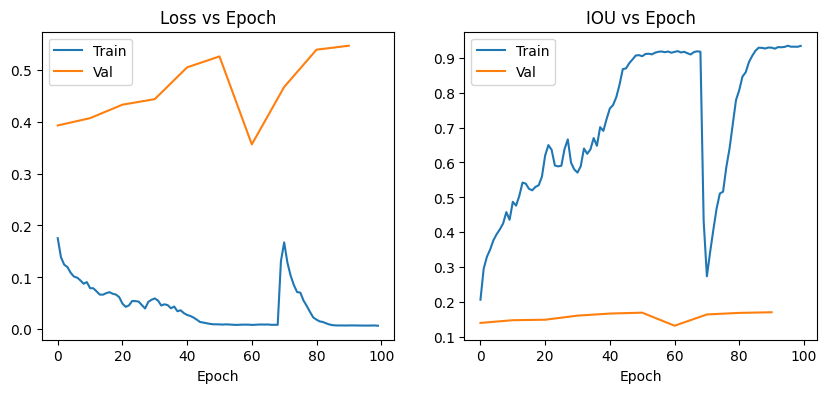

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
#plt.xticks(ax1,range(0,len(train_loss_list),5))

#ax1.set_xticklabels(range(0,len(train_loss_list),5))
ax1.plot(np.arange(0,len(train_loss_list),1),train_loss_list,label='Train')
ax1.plot(np.arange(0,10*len(val_loss_list),10),val_loss_list,label='Val')
ax1.set_xticks(range(0,len(train_loss_list)+1,20))
ax1.set_title('Loss vs Epoch')
ax1.set_xlabel('Epoch')
ax1.legend()

plt.xticks(range(0,len(train_loss_list),5))
ax2.plot(np.arange(0,len(train_iou_list),1),train_iou_list,label="Train")
ax2.plot(np.arange(0,10*len(val_iou_list),10),val_iou_list,label="Val")
ax2.set_xticks(range(0,len(train_iou_list)+1,20))
ax2.set_title('IOU vs Epoch')
ax2.set_xlabel('Epoch')
ax2.legend()

# 500 epochs

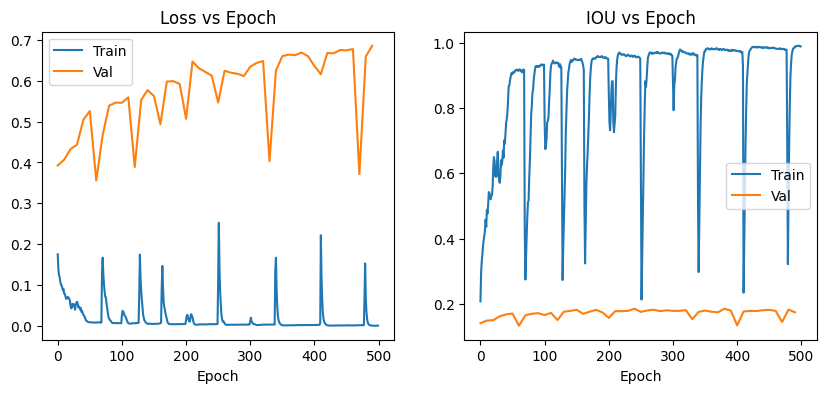

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
#plt.xticks(ax1,range(0,len(train_loss_list),5))

#ax1.set_xticklabels(range(0,len(train_loss_list),5))
ax1.plot(np.arange(0,len(train_loss_list),1),train_loss_list,label='Train')
ax1.plot(np.arange(0,10*len(val_loss_list),10),val_loss_list,label='Val')
ax1.set_xticks(range(0,len(train_loss_list)+1,100))
ax1.set_title('Loss vs Epoch')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(np.arange(0,len(train_iou_list),1),train_iou_list,label="Train")
ax2.plot(np.arange(0,10*len(val_iou_list),10),val_iou_list,label="Val")
ax2.set_xticks(range(0,len(train_iou_list)+1,100))
ax2.set_title('IOU vs Epoch')
ax2.set_xlabel('Epoch')
ax2.legend()